In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [3]:
from common.utils.image_preprocess import (
    get_slide_filename_from_image_id, get_mask_filename_from_image_id,
    read_slide, read_slide_partitions, read_slide_partition_file, read_mask_partition_file
)

In [4]:
import os
from openslide import open_slide
import matplotlib.pyplot as plt
import math
import numpy as np
from PIL import Image
from glob import glob

In [5]:
IMAGE_SOURCE_DIR = '../../../data/source_data/'
SAMPLE_IMG_ID = '091'

In [6]:
img_filepath = os.path.join(IMAGE_SOURCE_DIR,
                            get_slide_filename_from_image_id(SAMPLE_IMG_ID))

In [7]:
mask_filepath = os.path.join(IMAGE_SOURCE_DIR,
                             get_mask_filename_from_image_id(SAMPLE_IMG_ID))

In [8]:
slide = open_slide(img_filepath)

In [9]:
slide.level_dimensions

((61440, 53760),
 (30720, 26880),
 (15360, 13440),
 (7680, 6720),
 (3840, 3360),
 (1920, 1680),
 (960, 840),
 (480, 420))

In [10]:
slide.level_downsamples

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)

In [11]:
mask = open_slide(mask_filepath)

In [12]:
mask.level_dimensions

((61440, 53760),
 (30720, 26880),
 (15360, 13440),
 (7680, 6720),
 (3840, 3360),
 (1920, 1680),
 (960, 840),
 (480, 420))

In [13]:
mask.level_downsamples

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0)

In [14]:
# def read_slide_partitions(slide,
#                           level,
#                           partition_width=256,
#                           partition_height=256,
#                           include_padding=False,
#                           show_plot=False):
#     slide_height, slide_width = slide.level_dimensions[level]
#     downsample_factor = int(slide.level_downsamples[level])
    
#     if include_padding:
#         n_cols = math.ceil(slide_height / partition_height)
#         n_rows = math.ceil(slide_width / partition_width)
#     else:
#         n_cols = slide_height // partition_height
#         n_rows = slide_width // partition_width
    
#     partitions = []
    
#     for i in range(n_rows):
#         for j in range(n_cols):
#             x = j * partition_width * downsample_factor
#             y = i * partition_height * downsample_factor
            
#             partition_image = read_slide(slide,
#                                      x=x,
#                                      y=y,
#                                      level=level,
#                                      width=partition_width,
#                                      height=partition_height)
#             partitions.append(partition_image)
    
#     if show_plot:
#         fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
#         for idx in range(len(partitions)):
#             i = idx // n_cols
#             j = idx % n_cols
#             axes[i, j].imshow(partitions[idx])
#         plt.tight_layout()
#         plt.show()
    
#     return partitions

In [15]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])


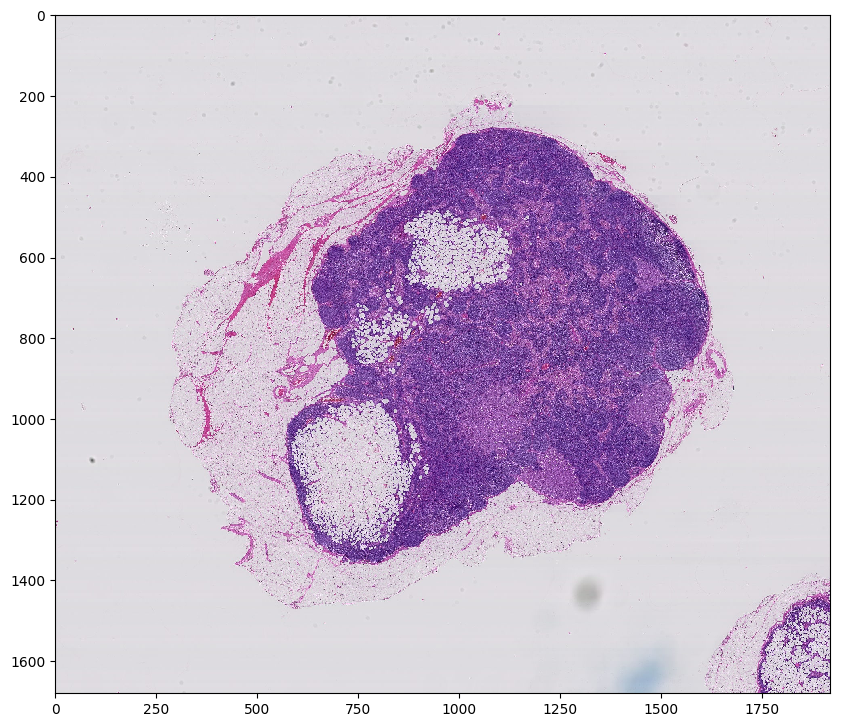

In [16]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

In [18]:
slide_file_prefix = 'temp/tumor_091_split'
mask_file_prefix = 'temp/tumor_mask_091_split'

In [19]:
partitions_slide = read_slide_partitions(
    slide,
    5,
    partition_width=256,
    partition_height=256,
#    show_plot=True,
#     save_mode=True,
#     save_file_prefix=save_file_prefix
)

In [20]:
partitions_mask = read_slide_partitions(
    mask,
    5,
    partition_width=256,
    partition_height=256,
    is_mask=True
)

In [22]:
def get_split_dimensions_from_partition_files(partition_files):
    rows = np.unique([x.split('.')[0].split('_')[-2] for x in partition_files])
    cols = np.unique([x.split('.')[0].split('_')[-1] for x in partition_files])
    return (len(rows), len(cols))

def plot_partition_file_paths(plot_axes, 
                              file_path_format, 
                              is_mask=False,
                              alpha=None):
    n_rows, n_cols = plot_axes.shape
    
    for i in range(n_rows):
        for j in range(n_cols):
            file_path = file_path_format.format(i, j)
            if is_mask:
                img_arr = read_mask_partition_file(file_path)
            else:
                img_arr = read_slide_partition_file(file_path)
            
            if alpha is None:
                plot_axes[i, j].imshow(img_arr)
            else:
                plot_axes[i, j].imshow(img_arr, alpha=alpha)

In [23]:
partition_slide_files = glob(slide_file_prefix + '*.png')
partition_mask_files = glob(mask_file_prefix + '*.npy')

In [24]:
partition_dims = get_split_dimensions_from_partition_files(partition_slide_files)

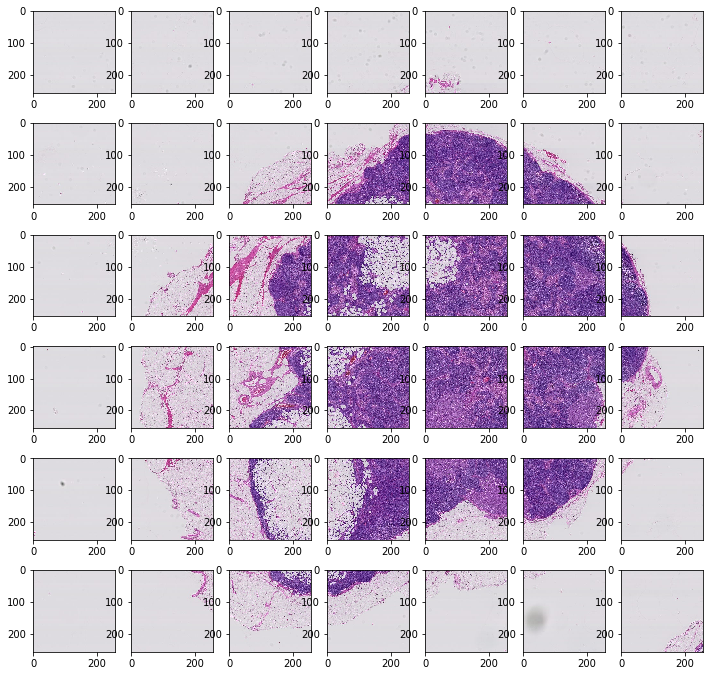

In [25]:
fig, axes = plt.subplots(partition_dims[0], partition_dims[1], figsize=(12, 12))
plot_partition_file_paths(axes, 'temp/tumor_091_split_{}_{}.png')

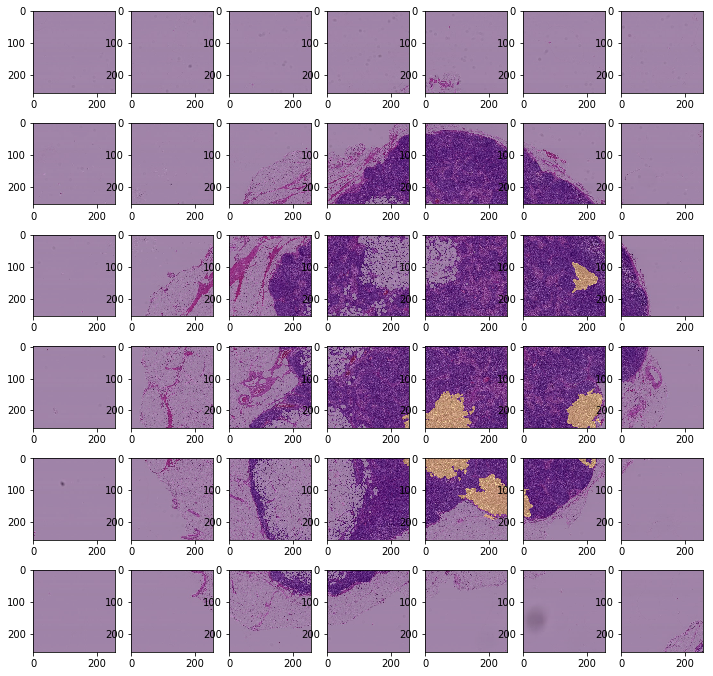

In [26]:
fig, axes = plt.subplots(partition_dims[0], partition_dims[1], figsize=(12, 12))
plot_partition_file_paths(axes, 'temp/tumor_091_split_{}_{}.png')
plot_partition_file_paths(axes, 'temp/tumor_mask_091_split_{}_{}.npy', is_mask=True, alpha=0.4)

In [27]:
n_rows, n_cols = partition_dims

In [28]:
# sanity check

In [29]:
slide_partition_file_format = 'temp/tumor_091_split_{}_{}.png'
mask_partition_file_format = 'temp/tumor_mask_091_split_{}_{}.npy'

In [40]:
for i in range(n_rows):
    for j in range(n_cols):
        slide_partition_file_path = slide_partition_file_format.format(i, j)
        mask_partition_file_path = mask_partition_file_format.format(i, j)
        
        slide_img_arr = read_slide_partition_file(slide_partition_file_path)
        mask_img_arr = read_mask_partition_file(mask_partition_file_path)
        
        idx_in_flattened = i * n_cols + j
        
        orig_slide_img_arr = partitions_slide[idx_in_flattened]
        orig_mask_img_arr = partitions_mask[idx_in_flattened]
        
        temp1 = np.abs(mask_img_arr - orig_mask_img_arr).sum()
        temp2 = np.abs(slide_img_arr - orig_slide_img_arr).sum()
        
        assert temp1 < 1e-8
        assert temp2 < 1e-8